In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sys
sys.path.append('modeling')
from viz import viz_interactive, viz, viz_map
from modeling import exponential_modeling
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
import load_data
from plotly.offline import init_notebook_mode, iplot
from fit_and_predict import add_preds
import json
from functions import update_severity_index as severity_index
from functions import emerging_index
plt.style.use('dark_background')
df = load_data.load_county_level()
df = df.sort_values('tot_deaths', ascending=False)
df = add_preds(df, NUM_DAYS_LIST=[1, 2, 3, 4, 5, 6, 7], cached_dir='data') # adds keys like "Predicted Deaths 1-day"
important_vars = load_data.important_keys(df)
print(df.keys())
df['tot_deaths_per_capita'] = df['tot_deaths'] / df['PopulationEstimate2018']
df['tot_cases_per_capita'] = df['tot_cases'] / df['PopulationEstimate2018']

Loading BokehJS ...

Loading BokehJS ...

loaded and merged COVID-19 cases/deaths data successfully
Index(['countyFIPS', 'STATEFP', 'COUNTYFP', 'CountyName', 'StateName', 'State',
       'lat', 'lon', 'POP_LATITUDE', 'POP_LONGITUDE',
       ...
       'neighbor_cases', 'y_preds_0', 'y_preds_1', 'Predicted Deaths 1-day',
       'Predicted Deaths 2-day', 'Predicted Deaths 3-day',
       'Predicted Deaths 4-day', 'Predicted Deaths 5-day',
       'Predicted Deaths 6-day', 'Predicted Deaths 7-day'],
      dtype='object', length=313)


## how many deaths/cases are there

In [2]:
df[['tot_deaths', 'tot_cases', 'StateName', 'CountyName', 'Predicted Deaths 1-day']].head(10)

,tot_deaths,tot_cases,StateName,CountyName,Predicted Deaths 1-day
1843,2672,31969,NY,Kings,2937.310135
1860,2604,36765,NY,Queens,2828.693411
1822,1771,24653,NY,Bronx,1933.826649
1849,1057,26715,NY,Nassau,1125.520846
1850,1019,16617,NY,New York,1090.272471
1304,884,12544,MI,Wayne,953.322905
1871,653,23278,NY,Suffolk,721.015160
1879,640,20947,NY,Westchester,699.319183
602,630,17306,IL,Cook,695.757022
1767,608,10848,NJ,Bergen,661.991115


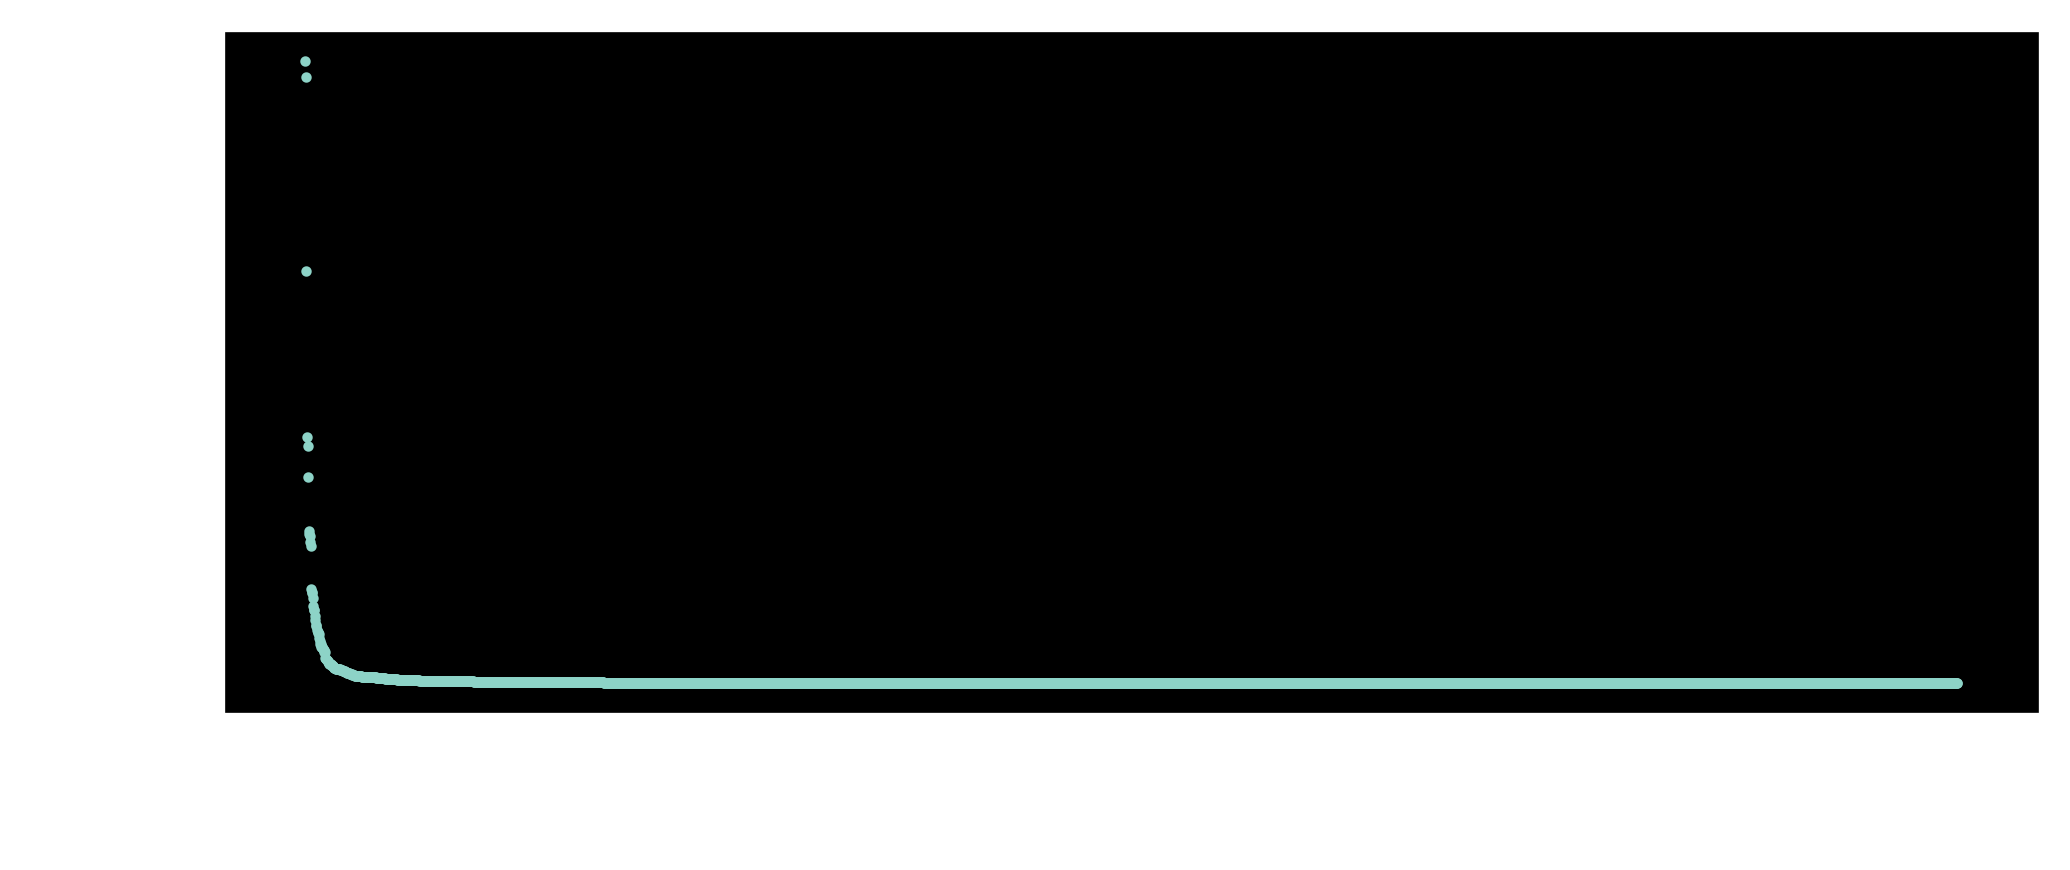

In [3]:
# s = f'Predicted Deaths {2}-day' # tot_deaths
s = 'tot_deaths'
num_days = 1
nonzero = df[s] > 0
plt.figure(dpi=300, figsize=(7, 3))
plt.plot(df[s].values, '.', ms=3)
plt.ylabel(s)
plt.xlabel('Counties')
# plt.yscale('log')
plt.tight_layout()
plt.show()

/Users/Tiffany/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/Users/Tiffany/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



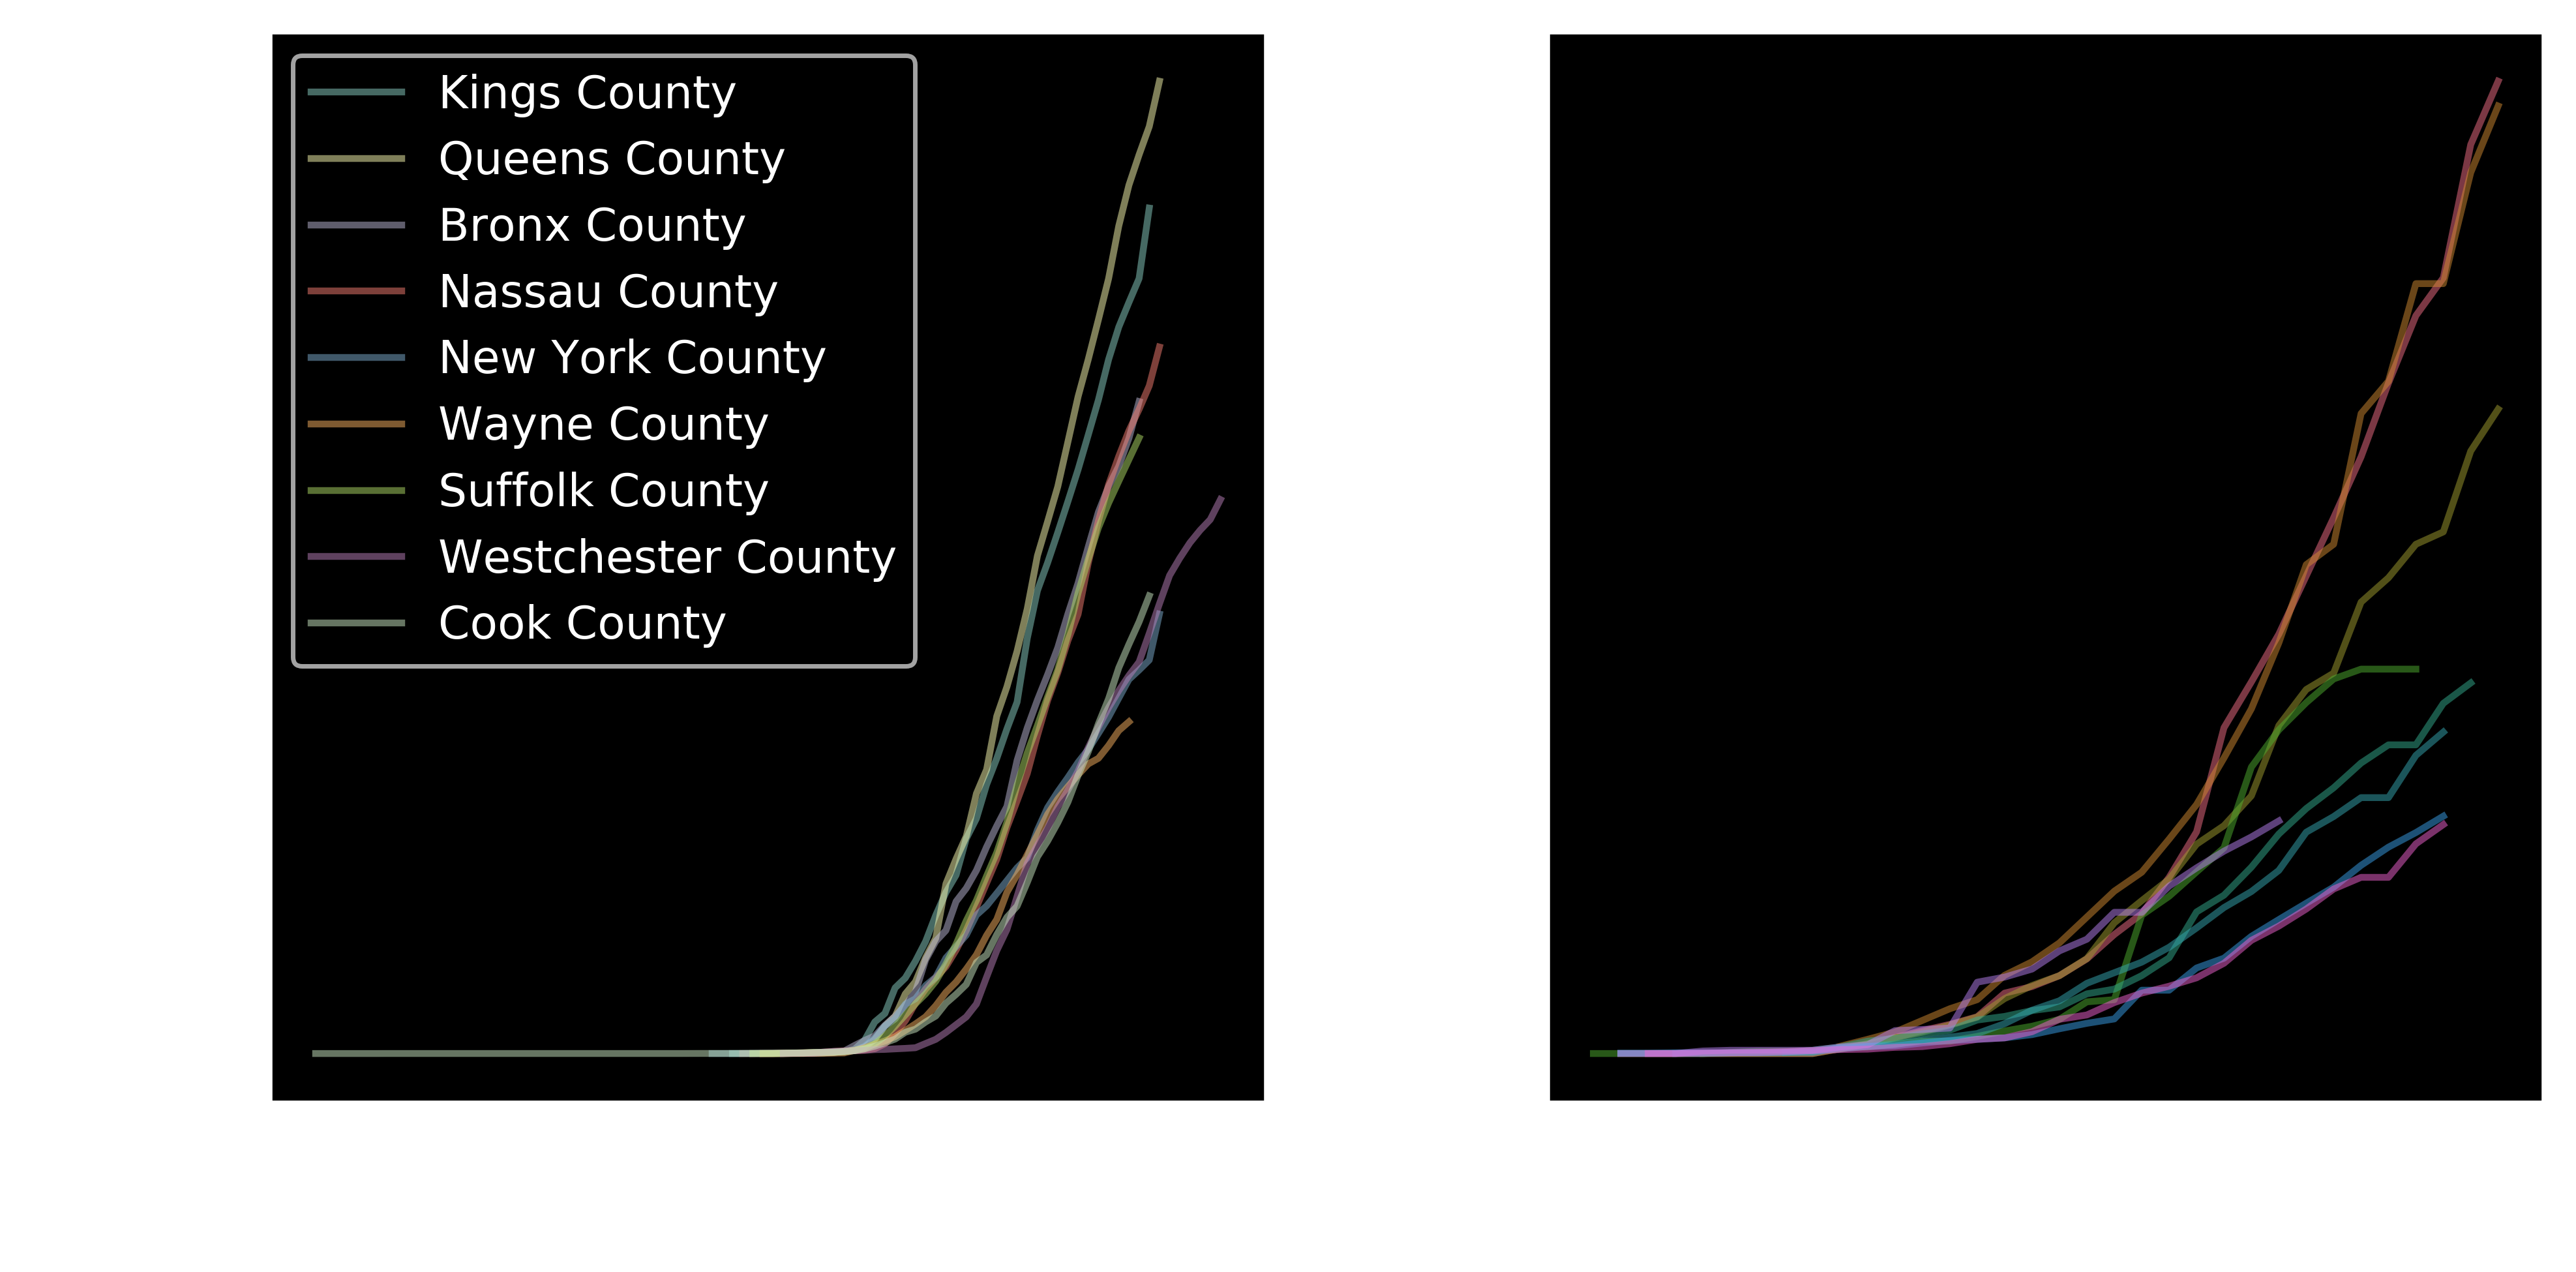

In [4]:
R, C = 1, 2
NUM_COUNTIES = 9
plt.figure(dpi=500, figsize=(8, 4))


# cs = sns.diverging_palette(20, 220, n=NUM_COUNTIES)
cs = sns.color_palette("husl", NUM_COUNTIES)
for i in range(NUM_COUNTIES):
    row = df.iloc[i]
    deaths = np.array([x for x in row['deaths'] if x > 0])
    cases = np.array([x for x in row['cases'] if x > 0])
    
    CASES_ALIGNMENT = 100
    idx_align = np.where(cases > CASES_ALIGNMENT)[0][0]
    n = cases.size
    
    DEATHS_ALIGNMENT = 10
    idx_align_deaths = np.where(deaths > DEATHS_ALIGNMENT)[0][0]
    n2 = deaths.size

    
    plt.subplot(R, C, 1)
    plt.plot(np.arange(n) - idx_align, cases, alpha=0.5, label=row['CountyName'] + ' County')#, color=cs[i])
#     plt.yscale('log')
    plt.ylabel('Cumulative confirmed cases')
    plt.xlabel(f'Days since {CASES_ALIGNMENT} cases')
    plt.legend()
    
    plt.subplot(R, C, 2)
    plt.plot(np.arange(n2) - idx_align_deaths, deaths, alpha=0.5, color=cs[i])
#     plt.yscale('log')
    plt.ylabel('Cumulative deaths')
    plt.xlabel(f'Days since {DEATHS_ALIGNMENT} deaths')
plt.tight_layout()
plt.show()

# correlations

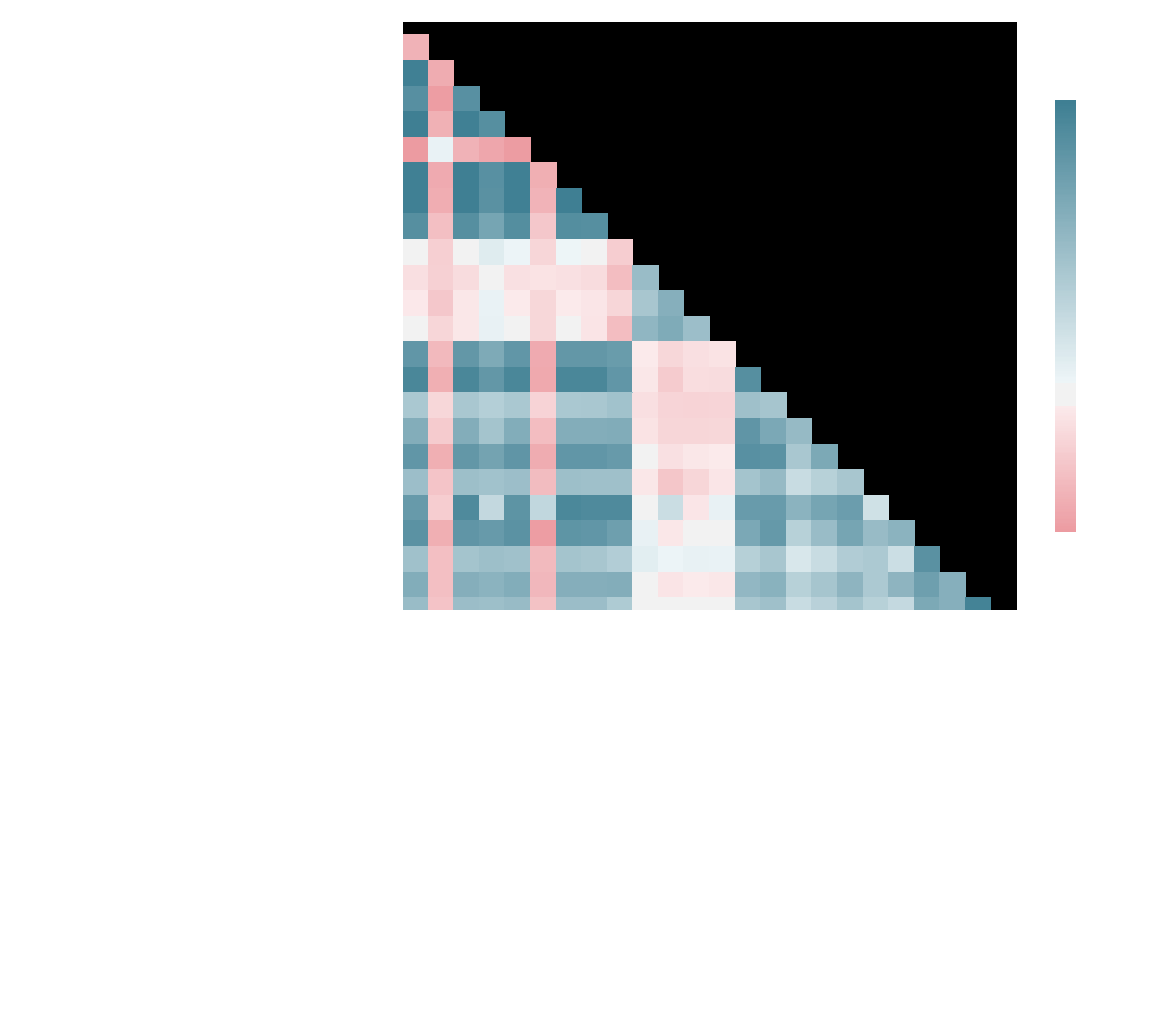

In [5]:
d = df[[k for k in important_vars if not 'PopMale' in k and not 'PopFmle' in k and not 'MortalityAge' in k and not 'PopTotal' in k] + 
        ['tot_cases', 'tot_cases_per_capita', 'tot_deaths', 'tot_deaths_per_capita']]

viz.corrplot(d)
plt.savefig('results/correlations_heatmap.png')
plt.show()

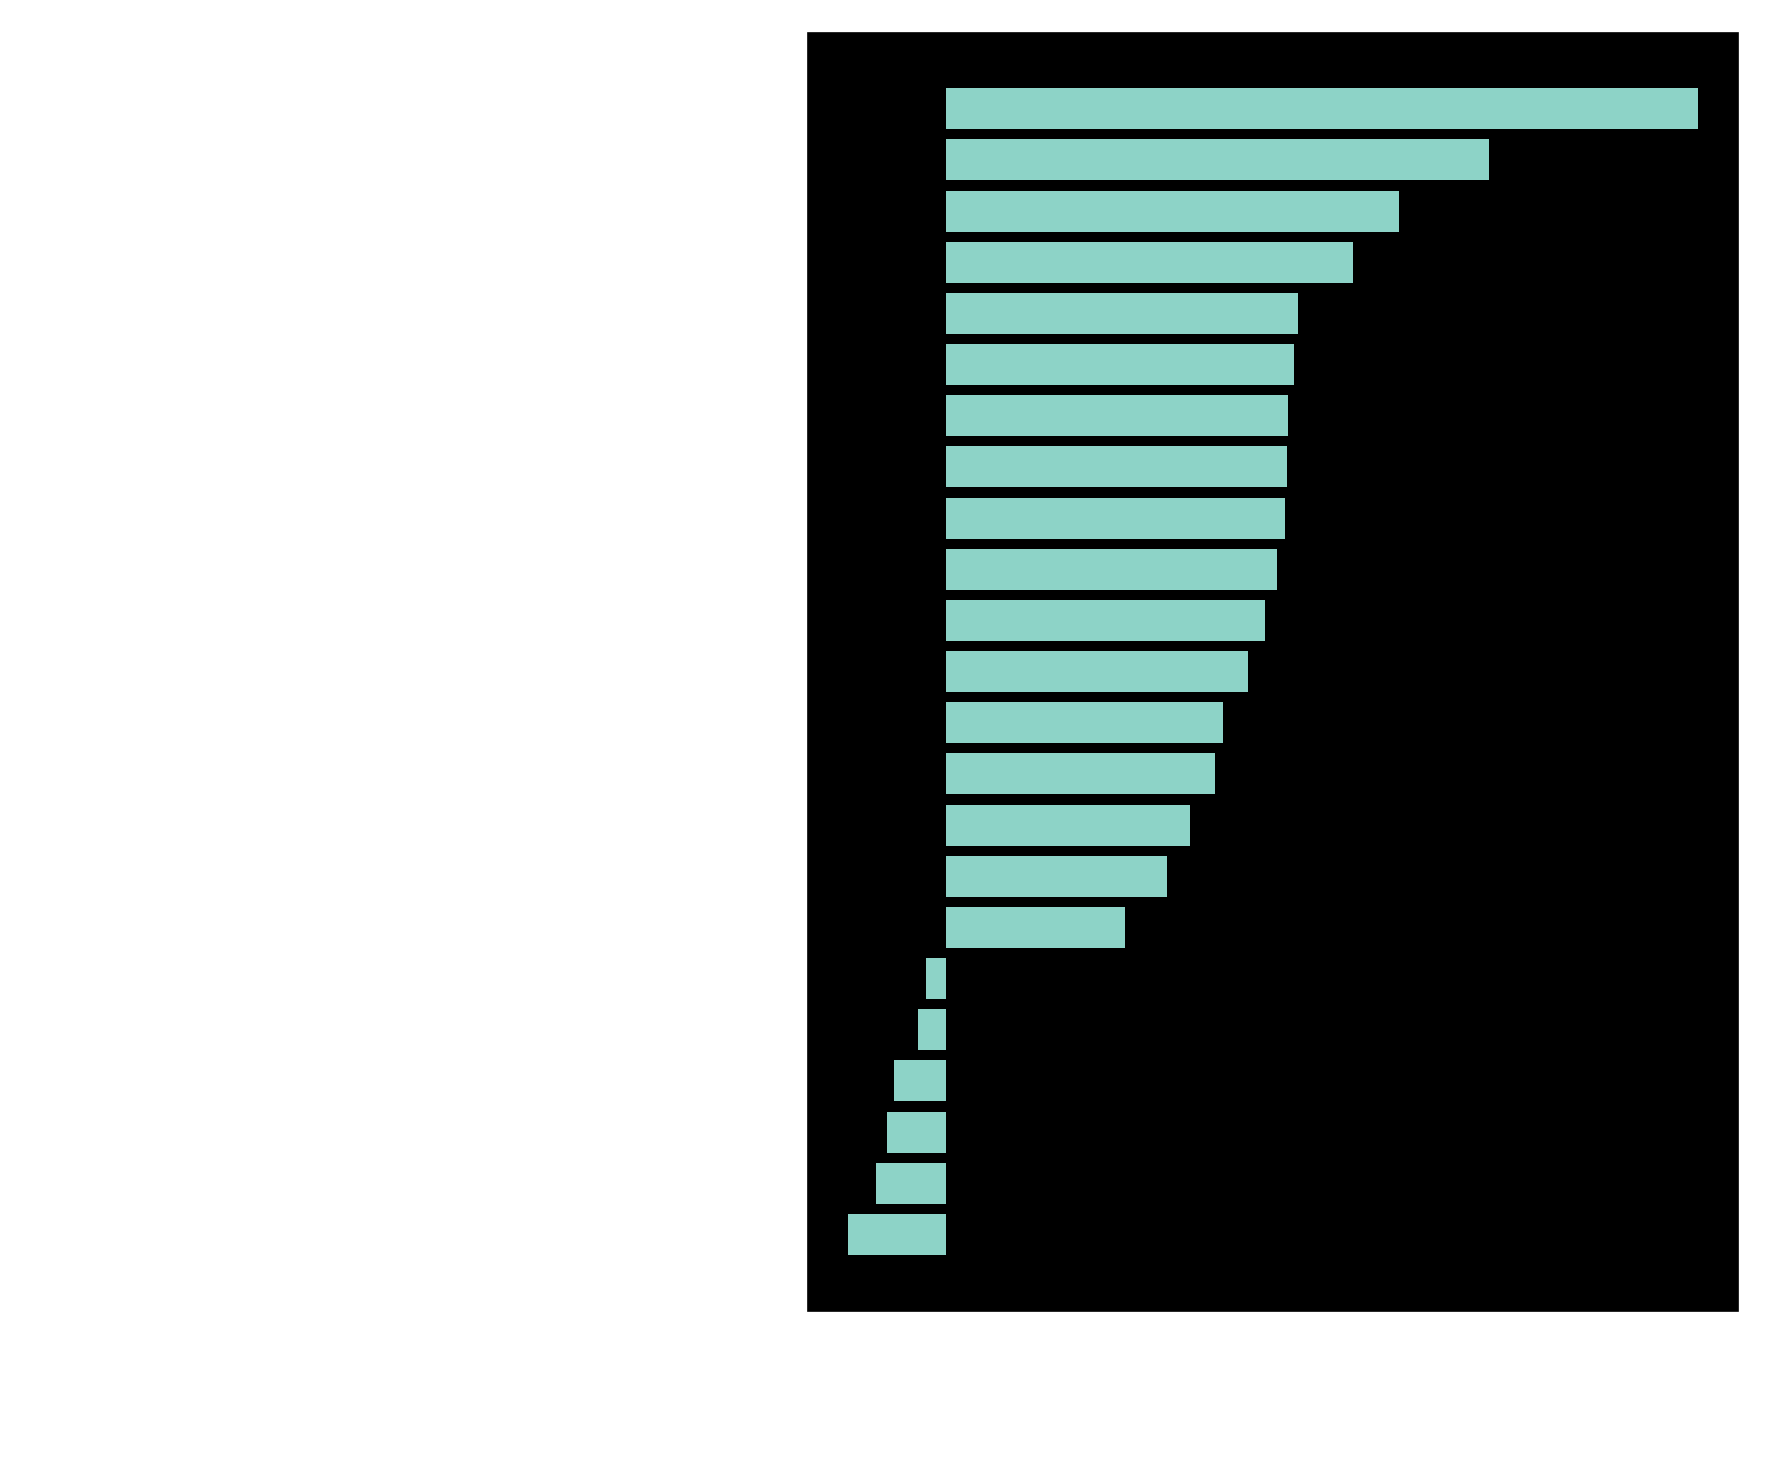

In [6]:
corrs = d.corr()
keys = np.array(corrs.index)
k = np.where(keys == 'tot_deaths')[0][0]
corrs_row = corrs.iloc[k]
args = np.argsort(corrs_row)
plt.figure(dpi=300, figsize=(6, 5))
plt.barh(keys[args][:-1], corrs_row[args][:-1]) # 1 to drop outcome itself
plt.xlabel('Correlation (spearman) with tot_deaths')
plt.tight_layout()
# plt.savefig('results/correlations.png')
plt.show()

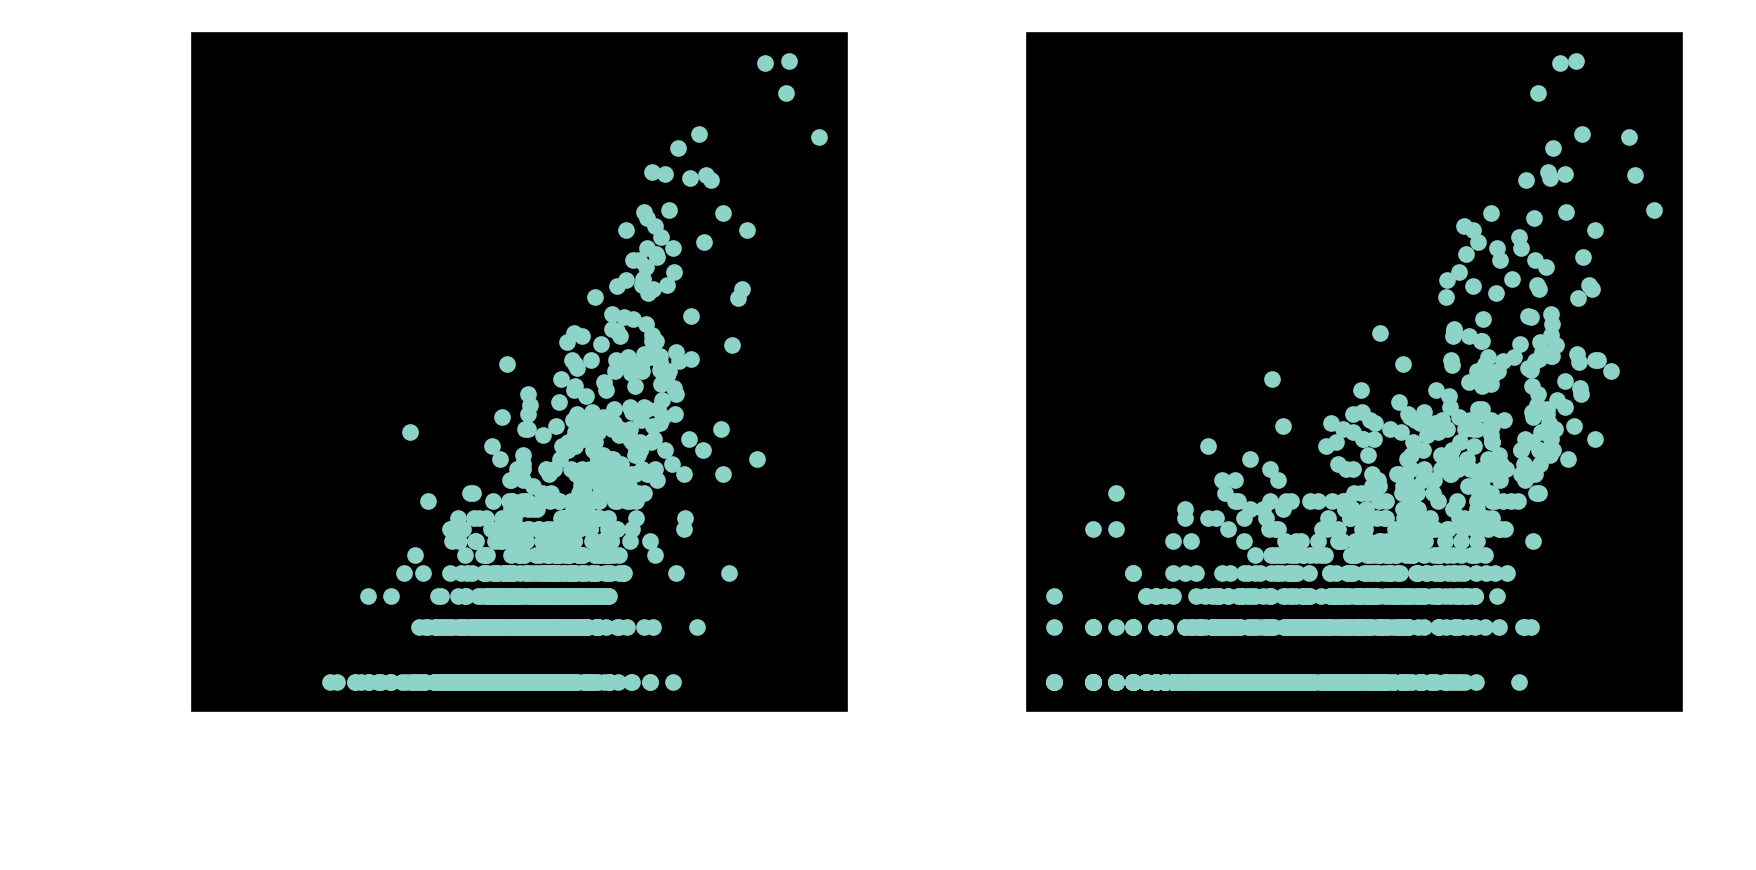

In [7]:
ks = ['PopulationDensityperSqMile2010', "TotalM.D.'s,TotNon-FedandFed2017"]
R, C = 1, len(ks)
plt.figure(dpi=300, figsize=(C * 3, R * 3))

for c in range(C):
    plt.subplot(R, C, c + 1)
    if c == 0:
        plt.ylabel('tot_deaths')
    plt.loglog(d[ks[c]], d['tot_deaths'], '.')
    plt.xlabel(ks[c])

plt.tight_layout()
plt.show()

# interactive plots

In [8]:
ks = [k for k in important_vars if not 'PopMale' in k
      and not 'PopFmle' in k
      and not 'MortalityAge' in k]

**individual states no slider**

In [9]:
# filter by state
for state in ['NY', 'WA', 'CA']:
    d = df[df["StateName"] == state]

    p = viz_map.plot_counties(d, 
                          variable_to_distribute='tot_cases',
                          variables_to_display=ks,
                          state=state,
                          logcolor=False)
    
#     output_file(f"results/{state.lower()}.html", mode='inline')
#     show(p)
#     save(p)

**counties slider**

In [10]:
# Just plot the bubbles... 
viz_map.plot_counties_slider(df)

In [11]:
# ...or plot choropleth too. Much slower and the map is less responsive
# read in county geojson
counties_json = json.load(open("data/geojson-counties-fips.json", "r"))
viz_map.plot_counties_slider(df, n_past_days=1, filename="results/deaths_choropleth.html", 
                                     plot_choropleth=True, counties_json=counties_json)

**political leaning**

In [12]:
# filter by state
for state in ['NY', 'WA', 'CA']:
    d = df[df["StateName"] == state]

    p = viz_map.plot_counties(d, 
                          variable_to_distribute='dem_to_rep_ratio',
                          variables_to_display=ks,
                          state=state,
                          logcolor=False)
    show(p)

**viz curves**

In [13]:
df_tab = df[['tot_deaths', 'tot_cases', 'CountyName', 'StateName', 
             'PopulationDensityperSqMile2010',
             'deaths', 'cases']].head(12)        
# df_tab = df_tab.rename(columns={'PopulationEstimate2018': 'Population\n(thousands})'})
df_tab = df_tab.rename(columns={'PopulationDensityperSqMile2010': 'PopDensity'})
df_tab = df_tab.rename(columns={'tot_deaths': '#Deaths', 'tot_cases': '#Cases'})
df_tab = df_tab.rename(columns={'CountyName': 'County', 'StateName': 'State'})
print(df_tab.keys())
# df_tab['Population']
keys_table = [k for k in df_tab.keys() if not k in ['deaths', 'cases']]
viz_interactive.viz_curves(df_tab, 
               key_toggle='County',
               keys_table=keys_table,
               filename='results/county_curves.html')
print('done!')

Index(['#Deaths', '#Cases', 'County', 'State', 'PopDensity', 'deaths',
       'cases'],
      dtype='object')
plot saved to results/county_curves.html
done!


**Emerging counties index**

In [14]:
target_days=[1,2,3,4,5]
n_days_past=5

In [15]:
emerging_index.add_emerging_index(df, target_days=target_days, n_days_past=n_days_past, min_deaths=15)
df.sort_values('emerging_index', ascending=False)[['CountyName', 'StateName', 'emerging_index',
                                                   '#Deaths_04-02-2020', '#Deaths_04-03-2020',
                                                   '#Deaths_04-04-2020', '#Deaths_04-05-2020', 
                                                   '#Deaths_04-06-2020', '#Deaths_04-07-2020', 
                                                   'Predicted Deaths 1-day', 'Predicted Deaths 2-day', 
                                                   'Predicted Deaths 3-day', 'Predicted Deaths 4-day',
                                                   'Predicted Deaths 5-day']].head(10)

,CountyName,StateName,emerging_index,#Deaths_04-02-2020,#Deaths_04-03-2020,#Deaths_04-04-2020,#Deaths_04-05-2020,#Deaths_04-06-2020,#Deaths_04-07-2020,Predicted Deaths 1-day,Predicted Deaths 2-day,Predicted Deaths 3-day,Predicted Deaths 4-day,Predicted Deaths 5-day
1784,Sussex,NJ,1.411857,7,8,9,9,11,15,43.322444,45.885610,48.496882,51.116515,51.555272
837,Linn,IA,1.080147,4,4,4,5,8,8,22.027578,23.420129,24.857643,26.676402,28.698702
93,Coconino,AZ,1.055225,8,10,10,10,10,10,24.955501,26.263008,27.658657,29.485490,31.176492
1834,Erie,NY,0.910186,19,22,26,27,30,39,113.439629,123.430456,134.236092,146.368411,161.625575
1787,Bernalillo,NM,0.569507,5,7,7,7,7,8,16.986282,18.056821,19.148948,20.370570,21.961179
1833,Dutchess,NY,0.528158,5,8,11,11,12,15,41.885804,45.639183,49.188459,52.470420,55.392407
268,Jefferson,CO,0.482234,9,13,15,17,18,21,33.602422,35.351895,37.025059,38.611813,40.001498
1769,Camden,NJ,0.395750,6,7,8,8,8,12,54.349719,60.729933,67.024993,73.044764,78.456023
412,Cobb,GA,0.383368,17,20,23,24,26,29,47.184616,50.675258,54.007444,57.346524,60.436117
2970,Pierce,WA,0.336797,7,7,8,10,12,15,29.629796,31.741088,33.681073,35.431600,36.845010


In [16]:
viz_map.plot_emerging_hotspots_grid(df, target_days=target_days, n_days_past=n_days_past)

In [17]:
emerging_index.add_emerging_index(df, 'emerging_index_2', target_days=target_days, 
                                  n_days_past=n_days_past, min_deaths=15)
df['emerging_index_diff'] = df['emerging_index'] - df['emerging_index_2']
df['emerging_index_rank'] = df['emerging_index'].rank()
df.sort_values('emerging_index_2', ascending=False)[['CountyName', 'StateName', 'emerging_index', 
                                                     'emerging_index_rank', 'emerging_index_2', 'emerging_index_diff',
                                                   '#Deaths_04-02-2020', '#Deaths_04-03-2020',
                                                   '#Deaths_04-04-2020', '#Deaths_04-05-2020', 
                                                   '#Deaths_04-06-2020', '#Deaths_04-07-2020', 
                                                   'Predicted Deaths 1-day', 'Predicted Deaths 2-day', 
                                                   'Predicted Deaths 3-day', 'Predicted Deaths 4-day',
                                                   'Predicted Deaths 5-day']].head(20)

,CountyName,StateName,emerging_index,emerging_index_rank,emerging_index_2,emerging_index_diff,#Deaths_04-02-2020,#Deaths_04-03-2020,#Deaths_04-04-2020,#Deaths_04-05-2020,#Deaths_04-06-2020,#Deaths_04-07-2020,Predicted Deaths 1-day,Predicted Deaths 2-day,Predicted Deaths 3-day,Predicted Deaths 4-day,Predicted Deaths 5-day
1784,Sussex,NJ,1.411857,3145.0,1.411857,0.0,7,8,9,9,11,15,43.322444,45.885610,48.496882,51.116515,51.555272
837,Linn,IA,1.080147,3144.0,1.080147,0.0,4,4,4,5,8,8,22.027578,23.420129,24.857643,26.676402,28.698702
93,Coconino,AZ,1.055225,3143.0,1.055225,0.0,8,10,10,10,10,10,24.955501,26.263008,27.658657,29.485490,31.176492
1834,Erie,NY,0.910186,3142.0,0.910186,0.0,19,22,26,27,30,39,113.439629,123.430456,134.236092,146.368411,161.625575
1787,Bernalillo,NM,0.569507,3141.0,0.569507,0.0,5,7,7,7,7,8,16.986282,18.056821,19.148948,20.370570,21.961179
1833,Dutchess,NY,0.528158,3140.0,0.528158,0.0,5,8,11,11,12,15,41.885804,45.639183,49.188459,52.470420,55.392407
268,Jefferson,CO,0.482234,3139.0,0.482234,0.0,9,13,15,17,18,21,33.602422,35.351895,37.025059,38.611813,40.001498
1769,Camden,NJ,0.395750,3138.0,0.395750,0.0,6,7,8,8,8,12,54.349719,60.729933,67.024993,73.044764,78.456023
412,Cobb,GA,0.383368,3137.0,0.383368,0.0,17,20,23,24,26,29,47.184616,50.675258,54.007444,57.346524,60.436117
2970,Pierce,WA,0.336797,3136.0,0.336797,0.0,7,7,8,10,12,15,29.629796,31.741088,33.681073,35.431600,36.845010
